## <b><u><font color=blue> Skin Cancer type detection</u></font> utilising custom Deep Learning model for classification </b>

### Importing required libraries and Input Data (using zip file uploaded on drive)

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# adding drive to google colabs content
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping source data
# source data path : '/content/drive/MyDrive/Melanoma_CS/CNN_assignment.zip'
# destination data path : '/content/drive/MyDrive/Melanoma_CS/'
!unzip '/content/drive/MyDrive/Melanoma_CS/CNN_assignment.zip' -d '/content/drive/MyDrive/Melanoma_CS/'

In [4]:
# Path for train and test images for further workings, <please change if need be from default>
train_data_path = "/content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
# Validation to test if all images have been loaded in train & test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


There are total <b>2357 images</b> of various skin cancer types. There are <b>2239 train images and 118 test images</b>, also both train and test constitute 9 sub-directories depicting <i><font color=blue>9 skin cancer types</i></font> respectively.

### Loading images into dataset using keras preprocessing library

In [6]:
# parameters for loading as per instructions
batch_size = 32
img_height = 180
img_width = 180
train_validation_split = 0.2
seed_split = 100

In [ ]:
# train and validation dataset creation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_split,
  validation_split = train_validation_split,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_split,
  validation_split = train_validation_split,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [8]:
# looking at different class types of skin cancer
skin_types = train_ds.class_names
print(skin_types)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizaing data, one image per class

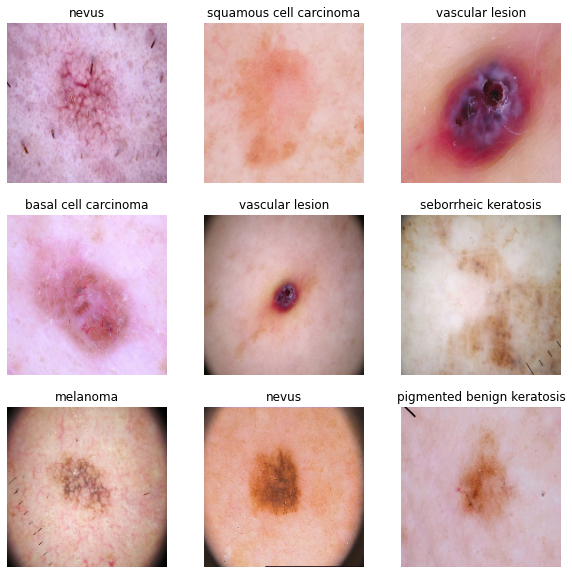

In [ ]:
# Visualizing first 9 images in a batch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(skin_types[labels[i]])
    plt.axis("off")


cancer_type: actinic keratosis batch_number: 1 image_number: 6


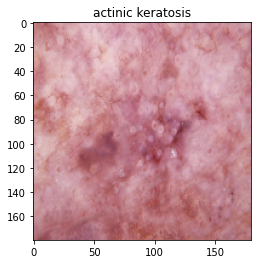

cancer_type: basal cell carcinoma batch_number: 1 image_number: 6


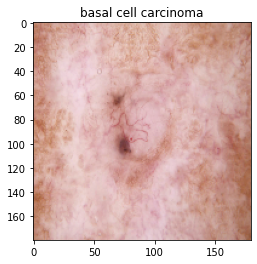

cancer_type: dermatofibroma batch_number: 1 image_number: 5


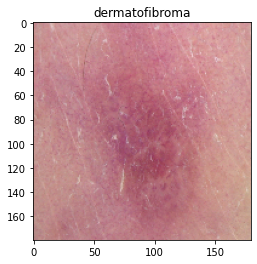

cancer_type: melanoma batch_number: 1 image_number: 5


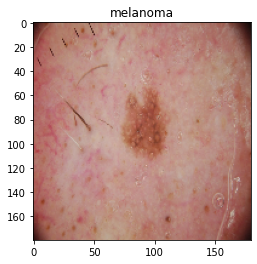

cancer_type: nevus batch_number: 1 image_number: 0


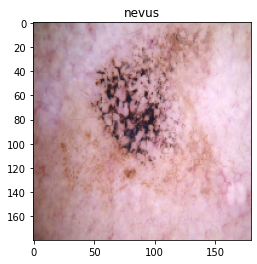

cancer_type: pigmented benign keratosis batch_number: 1 image_number: 0


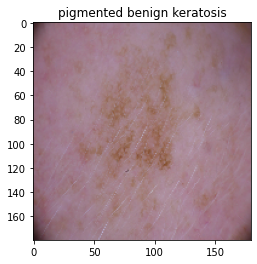

cancer_type: seborrheic keratosis batch_number: 1 image_number: 0


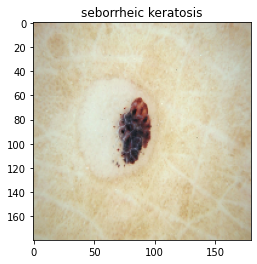

cancer_type: squamous cell carcinoma batch_number: 1 image_number: 1


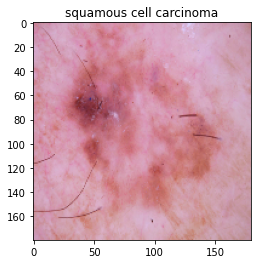

cancer_type: vascular lesion batch_number: 1 image_number: 8


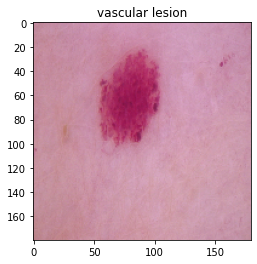

In [ ]:
# As we can see duplicate classes if we go by sequence, below is custom code to visualize one image per class (cancer type)

# Finding batch number and image number of each class (so as to get one image per class to visualize)
image_finder_df = pd.DataFrame(columns=['cancer_type', 'batch_number', 'image_number'])

# Assuming in first three batches of 32 images itself we can find atleast 1 image of each class, else increase maximum_batches_lookup
maximum_batches_lookup = 3

for cancer_type in skin_types:
  found = 0
  batch_number = 1
  while found == 0 and batch_number <= maximum_batches_lookup:
    for images, labels in train_ds.take(batch_number):
      counter = 0
      while counter < 32 and found == 0: 
          if skin_types[labels[counter]] == cancer_type:
            print("cancer_type:", cancer_type, "batch_number:",batch_number, "image_number:",counter)
            image_finder_df.append({"cancer_type": cancer_type, "batch_number":batch_number, "image_number":counter}, ignore_index=True)
            plt.imshow(images[counter].numpy().astype("uint8"))
            plt.title(cancer_type)
            plt.show()
            found = 1
          counter += 1
    batch_number += 1
# plt.show()

In [ ]:
print("Type of data: ",type(train_ds))
print("Number of batches: ",len(train_ds))
print("Total Images: ",batch_size*len(train_ds))


Type of data:  <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Number of batches:  56
Total Images:  1792


Each image_batch is a tensor of the shape <b>`(32, 180, 180, 3)`</b> which means there are <font color = blue>32 images in each batch and each image is of size `180*180*3` where 3 represents color channels RGB</font>. In total there are <b>56 batches in train data</b> as can be seen above

In [10]:
# Using Dataset.cache() and Dataset.prefetch() for optimization where cache function keeps the images in memory after they're loaded off disk during the first epoch and 
# prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation: We will test 3-4 iterations experimenting with Vanilla model, with dropout, with batch normalization and both based on if we see some overfitting happening
#### We will also use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.

In [ ]:
# Vanilla model of type sequential using 4 convolutional & pooling layers, a flatten layer and dense layer at the end
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # 2D convolution layer with 16 filters
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # 2D convolution layer with 32 filters
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # 2D convolution layer with 64 filters
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # 2D convolution layer with 128 filters
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # Flattening the input without affecting the batch size.
  layers.Flatten(),
  # Adding a dense layer
  layers.Dense(256, activation='relu'),
  # Adding final dense layer
  layers.Dense(len(skin_types))
])

In [ ]:
# Detailed summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
# Using adam as the gradient boosting based optimizer and Cross entropy as the loss function
# Using accuracy as the accuracy metrics, it can be replaced with precision or recall as well based on business needs
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 109s 2s/step - loss: 2.0985 - accuracy: 0.2210 - val_loss: 1.9474 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 86s 2s/step - loss: 1.8670 - accuracy: 0.3220 - val_loss: 1.7092 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 90s 2s/step - loss: 1.6175 - accuracy: 0.4102 - val_loss: 1.6393 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 82s 1s/step - loss: 1.5773 - accuracy: 0.4431 - val_loss: 1.6403 - val_accuracy: 0.4116
Epoch 5/20
56/56 [==============================] - 116s 2s/step - loss: 1.4992 - accuracy: 0.4682 - val_loss: 1.4927 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 94s 2s/step - loss: 1.3979 - accuracy: 0.5089 - val_loss: 1.4665 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 94s 2s/step - loss: 1.3238 - accuracy: 0.5301 - val_loss: 1.3687 - val_accuracy: 0.5123
Epoch 8/20
56/56 [

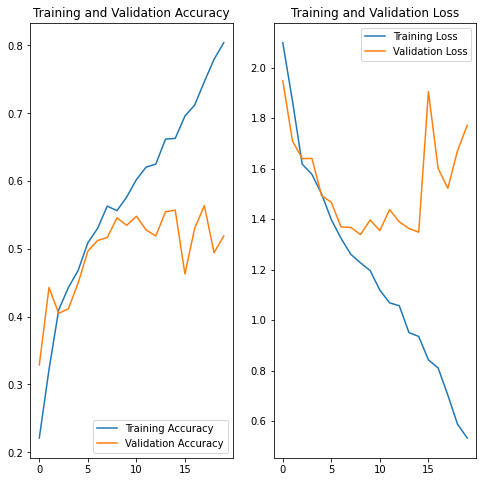

In [ ]:
# Accuracy & loss plot variation with epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

`[Vanilla Model Iteration] ::` We can see <b>overfitting</b> as per train (81) and validation accuracy (52) as well as loss. <b>Next steps</b> to try in order to reduce overfitting are : <font color=blue>reduce complexity of network and add dropout, then try adding batch normalization</font>

### Vanilla Model removing last layer of Conv2D & Pool2D and adding dropout

In [ ]:
# Vanilla model of type sequential using 3 convolutional & pooling layers, a flatten layer and dense layer at the end
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # 2D convolution layer with 16 filters
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 32 filters
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 64 filters
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # Flattening the input without affecting the batch size.
  layers.Flatten(),
  # Adding a dense layer
  layers.Dense(128, activation='relu'),
  # Adding final dense layer
  layers.Dense(len(skin_types))
])

In [ ]:
# Detailed summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
# Using adam as the gradient boosting based optimizer and Cross entropy as the loss function
# Using accuracy as the accuracy metrics, it can be replaced with precision or recall as well based on business needs
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 82s 1s/step - loss: 2.6521 - accuracy: 0.1652 - val_loss: 2.0570 - val_accuracy: 0.1409
Epoch 2/20
56/56 [==============================] - 83s 1s/step - loss: 2.0195 - accuracy: 0.2160 - val_loss: 2.0837 - val_accuracy: 0.2617
Epoch 3/20
56/56 [==============================] - 85s 2s/step - loss: 1.9064 - accuracy: 0.3008 - val_loss: 2.0122 - val_accuracy: 0.2886
Epoch 4/20
56/56 [==============================] - 83s 1s/step - loss: 1.7605 - accuracy: 0.3689 - val_loss: 1.8033 - val_accuracy: 0.3870
Epoch 5/20
56/56 [==============================] - 91s 2s/step - loss: 1.5860 - accuracy: 0.4392 - val_loss: 1.6599 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 85s 1s/step - loss: 1.5309 - accuracy: 0.4626 - val_loss: 1.6981 - val_accuracy: 0.4228
Epoch 7/20
56/56 [==============================] - 84s 2s/step - loss: 1.4462 - accuracy: 0.4955 - val_loss: 1.6315 - val_accuracy: 0.3960
Epoch 8/20
56/56 [==

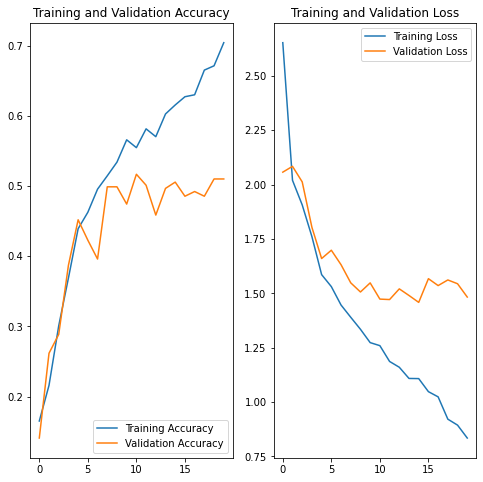

In [ ]:
# Accuracy & loss plot variation with epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

`[Vanilla Model Less Complexity + Dropout Iteration] ::` We can see <b>overfitting has reduced from previous iteration</b> but there is still significant difference between train and validation accuracy.

### Vanilla Model removing last layer of Conv2D & Pool2D and adding batch normalization

In [ ]:
# Vanilla model of type sequential using 3 convolutional & pooling layers, a flatten layer and dense layer at the end
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # 2D convolution layer with 16 filters
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add batch normalization
  layers.BatchNormalization(),
  # 2D convolution layer with 32 filters
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add batch normalization
  layers.BatchNormalization(),
  # 2D convolution layer with 64 filters
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add batch normalization
  layers.BatchNormalization(),
  # Flattening the input without affecting the batch size.
  layers.Flatten(),
  # Adding a dense layer
  layers.Dense(128, activation='relu'),
  # Adding final dense layer
  layers.Dense(len(skin_types))
])

In [ ]:
# Detailed summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 32)      

In [ ]:
# Using adam as the gradient boosting based optimizer and Cross entropy as the loss function
# Using accuracy as the accuracy metrics, it can be replaced with precision or recall as well based on business needs
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 88s 2s/step - loss: 3.5944 - accuracy: 0.3041 - val_loss: 8.8690 - val_accuracy: 0.0761
Epoch 2/20
56/56 [==============================] - 79s 1s/step - loss: 1.6781 - accuracy: 0.4191 - val_loss: 13.9908 - val_accuracy: 0.0761
Epoch 3/20
56/56 [==============================] - 77s 1s/step - loss: 1.4624 - accuracy: 0.4860 - val_loss: 17.4398 - val_accuracy: 0.1432
Epoch 4/20
56/56 [==============================] - 77s 1s/step - loss: 1.2800 - accuracy: 0.5402 - val_loss: 17.0030 - val_accuracy: 0.1790
Epoch 5/20
56/56 [==============================] - 75s 1s/step - loss: 1.1189 - accuracy: 0.5910 - val_loss: 15.4922 - val_accuracy: 0.1544
Epoch 6/20
56/56 [==============================] - 76s 1s/step - loss: 0.9949 - accuracy: 0.6473 - val_loss: 12.4959 - val_accuracy: 0.1745
Epoch 7/20
56/56 [==============================] - 78s 1s/step - loss: 0.8624 - accuracy: 0.6886 - val_loss: 4.2560 - val_accuracy: 0.2371
Epoch 8/20
56/5

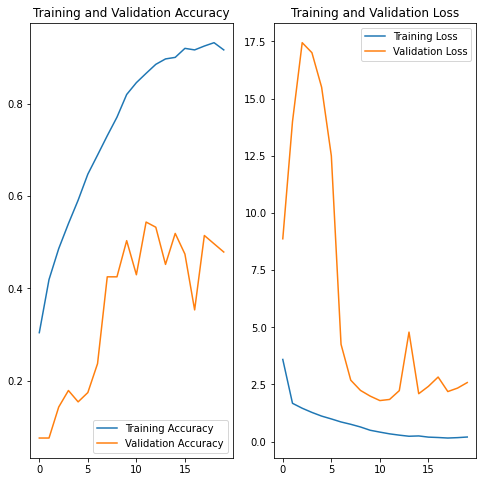

In [ ]:
# Accuracy & loss plot variation with epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

`[Vanilla Model Less Complexity + Batch Normalizarion Iteration] ::` We can see <b>Batch Normalization doesn't help reduce overfitting</b>. <font color=blue>But as <b> next step</b> to further reduce Overfitting with the initial model + dropout, we can apply <u>augmentation for images</u></font>

### Vanilla Model removing last layer of Conv2D & Pool2D and adding batch normalization + DATA AUGMENTATION

In [11]:
# Created data augmentation strategy with different types of transformations
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

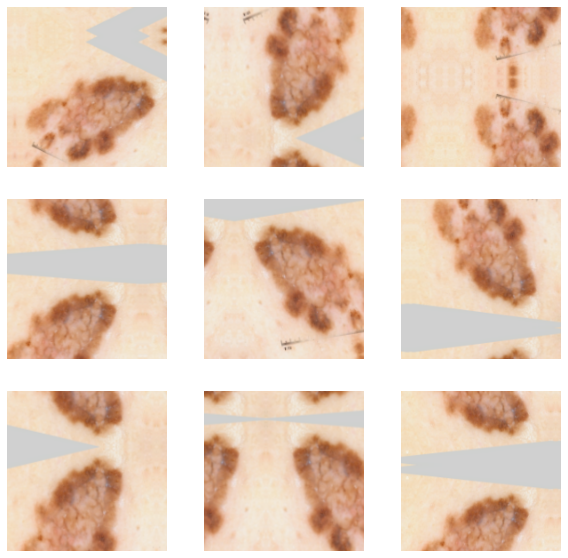

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Model creation with data augmentation
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # 2D convolution layer with 16 filters
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 32 filters
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 64 filters
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 64 filters
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # Flattening the input without affecting the batch size.
  layers.Flatten(),
  # Adding a dense layer
  layers.Dense(256, activation='relu'),
  # Adding final dense layer
  layers.Dense(len(skin_types))
])

In [ ]:
# Using adam as the gradient boosting based optimizer and Cross entropy as the loss function
# Using accuracy as the accuracy metrics, it can be replaced with precision or recall as well based on business needs
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 128s 2s/step - loss: 2.0792 - accuracy: 0.2109 - val_loss: 2.0199 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 118s 2s/step - loss: 1.8620 - accuracy: 0.3175 - val_loss: 1.8422 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 115s 2s/step - loss: 1.7348 - accuracy: 0.3421 - val_loss: 1.7799 - val_accuracy: 0.3557
Epoch 4/20
56/56 [==============================] - 116s 2s/step - loss: 1.6731 - accuracy: 0.3566 - val_loss: 1.6715 - val_accuracy: 0.3848
Epoch 5/20
56/56 [==============================] - 118s 2s/step - loss: 1.6909 - accuracy: 0.3728 - val_loss: 1.7070 - val_accuracy: 0.3758
Epoch 6/20
56/56 [==============================] - 116s 2s/step - loss: 1.6217 - accuracy: 0.3817 - val_loss: 1.6645 - val_accuracy: 0.3758
Epoch 7/20
56/56 [==============================] - 119s 2s/step - loss: 1.6251 - accuracy: 0.3890 - val_loss: 1.8755 - val_accuracy: 0.3423
Epoch 8/20
56/56 [======

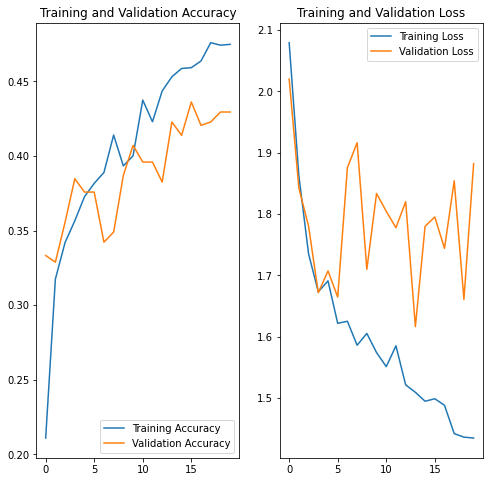

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

`[Vanilla Model Less Complexity + Dropout + Data Augmentation Iteration] ::` We can see <b>overfitting has reduced by a lot extent</b> and this shows data augmentation worked out really well and improve the overall model. Next step to further improve the model accuracy is to check if there is any class imbalance and treat it

### Vanilla Model removing last layer of Conv2D & Pool2D and adding dropouts + DATA AUGMENTATION + CLASS IMBALANCE VALIDATION & TREATMENT

In [ ]:
# Creating dataframe with image path and label
from glob import glob
image_paths = [path for path in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
labels_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(image_paths)

2239

In [ ]:
collection_dict = dict(zip(image_paths, labels_list))
collection_df = pd.DataFrame(list(collection_dict.items()),columns = ['Path','Label'])
collection_df.head()

,Path,Label
0,/content/drive/MyDrive/Melanoma_CS/Skin cancer...,actinic keratosis
1,/content/drive/MyDrive/Melanoma_CS/Skin cancer...,actinic keratosis
2,/content/drive/MyDrive/Melanoma_CS/Skin cancer...,actinic keratosis
3,/content/drive/MyDrive/Melanoma_CS/Skin cancer...,actinic keratosis
4,/content/drive/MyDrive/Melanoma_CS/Skin cancer...,actinic keratosis


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


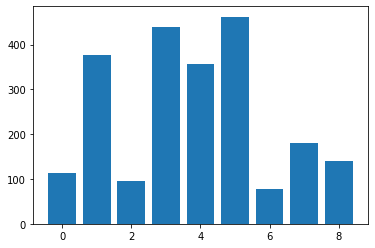

Class Mapping:  {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Class Sample Share:  {0: 5.09, 1: 16.79, 2: 4.24, 3: 19.56, 4: 15.94, 5: 20.63, 6: 3.44, 7: 8.08, 8: 6.21}


In [ ]:
# Computing percentage of images by class
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = collection_df['Path'], collection_df['Label']
# label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
le_class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# summarize distribution
counter = Counter(y)
weight_dict = {}
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
	weight_dict[k] = round(per,2)
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()
print("Class Mapping: ",le_class_mapping)
print("Class Sample Share: ", weight_dict)

We can see <b><font color=red> seborrheic keratosis (3.43%) and dermatofibroma (4.24%) have the least number of samples </font></b>, however, <font color = blue><b>pigmented benign keratosis (20.63%) and melanoma (19.56%) cancer type have highest number of samples</font></b>. Also, we should be targeting to increase number of samples close to 400 for all lower sample share classes. 

### Rectifying imbalance by adding more samples

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using `Augmentor` following below steps learned:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# path_to_training_dataset="/content/gdrive/MyDrive/SC/Train//"
import Augmentor
for i in skin_types:
    p = Augmentor.Pipeline(train_data_path + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF354076C10>: 100%|██████████| 500/500 [00:27<00:00, 18.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF3456298B0>: 100%|██████████| 500/500 [00:25<00:00, 19.25 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF354074CA0>: 100%|██████████| 500/500 [00:27<00:00, 18.33 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF33FDC3E80>: 100%|██████████| 500/500 [02:03<00:00,  4.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FF33F564C10>: 100%|██████████| 500/500 [01:59<00:00,  4.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF3456EF520>: 100%|██████████| 500/500 [00:27<00:00, 18.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF33F2F5D30>: 100%|██████████| 500/500 [00:57<00:00,  8.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF33F4DE8B0>: 100%|██████████| 500/500 [00:26<00:00, 19.06 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_CS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF3457098B0>: 100%|██████████| 500/500 [00:26<00:00, 18.71 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
image_paths = [path for path in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
labels_list = [(path.split("/"))[-3] for path in image_paths]

In [ ]:
collection_dict = dict(zip(image_paths, labels_list))
collection_df_augmented = pd.DataFrame(list(collection_dict.items()),columns = ['Path','Label'])
collection_df = collection_df.append(collection_df_augmented)

In [ ]:
collection_df.groupby('Label').count()

,Path
Label,
actinic keratosis,614
basal cell carcinoma,876
dermatofibroma,595
melanoma,938
nevus,857
pigmented benign keratosis,962
seborrheic keratosis,577
squamous cell carcinoma,681
vascular lesion,639


### Vanilla Model removing last layer of Conv2D & Pool2D and adding dropouts + DATA AUGMENTATION + CLASS IMBALANCE TREATMENT

In [9]:
# train and validation dataset creation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_split,
  validation_split = train_validation_split,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_split,
  validation_split = train_validation_split,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [12]:
# Model creation with data augmentation
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # 2D convolution layer with 16 filters
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 32 filters
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 64 filters
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # 2D convolution layer with 64 filters
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # add dropout
  layers.Dropout(0.2),
  # Flattening the input without affecting the batch size.
  layers.Flatten(),
  # Adding a dense layer
  layers.Dense(256, activation='relu'),
  # Adding final dense layer
  layers.Dense(len(skin_types))
])

In [13]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# taking 30 epochs in final interation as instructed to conclude, however saved output is from executing 20 epochs as gpu free access quota ended, kindly rerun to view 30 epochs based output
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 [==============================] - 122s 441ms/step - loss: 2.2341 - accuracy: 0.1376 - val_loss: 2.1662 - val_accuracy: 0.1307
Epoch 2/30
169/169 [==============================] - 67s 399ms/step - loss: 1.9872 - accuracy: 0.2120 - val_loss: 1.8798 - val_accuracy: 0.2472
Epoch 3/30
169/169 [==============================] - 69s 409ms/step - loss: 1.7827 - accuracy: 0.2697 - val_loss: 1.7358 - val_accuracy: 0.2606
Epoch 4/30
169/169 [==============================] - 65s 383ms/step - loss: 1.7666 - accuracy: 0.2936 - val_loss: 1.7960 - val_accuracy: 0.2739
Epoch 5/30
169/169 [==============================] - 66s 388ms/step - loss: 1.6954 - accuracy: 0.3210 - val_loss: 1.8217 - val_accuracy: 0.2635
Epoch 6/30
169/169 [==============================] - 65s 388ms/step - loss: 1.6623 - accuracy: 0.3386 - val_loss: 2.0302 - val_accuracy: 0.2235
Epoch 7/30
169/169 [==============================] - 67s 397ms/step - loss: 1.5698 - accuracy: 0.3871 - val_loss: 2.0524 - val_accuracy: 0.

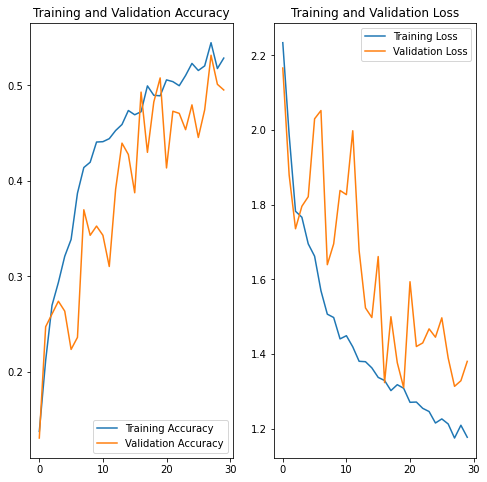

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b><u><font color=blue>CONCLUSION:</font></b></u> With the final iteraton we have managed to eliminate overfitting and the overall accuracy has also increased considerably, thus reducing underfitting as well. <br><br>From all the iterations the final successful model came after having <b><font color=purple><i> 3 convolution and pooling later along with flatten and dense, later adding dropouts, image augmentation in general, and image augmentation to reduce class imbalance separately <b></font></i><br><br>One last iteration testing removing dropouts to increase accuracy as the expectation is that data augmentation itself is taking care of accuracy

### Vanilla Model removing last layer of Conv2D & Pool2D  + DATA AUGMENTATION + CLASS IMBALANCE TREATMENT

In [16]:
# Model creation with data augmentation
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # 2D convolution layer with 16 filters
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # 2D convolution layer with 32 filters
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # 2D convolution layer with 64 filters
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # 2D convolution layer with 64 filters
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  # 2D pooling layer of default max type 
  layers.MaxPooling2D(),
  # Flattening the input without affecting the batch size.
  layers.Flatten(),
  # Adding a dense layer
  layers.Dense(256, activation='relu'),
  # Adding final dense layer
  layers.Dense(len(skin_types))
])

In [17]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# taking 30 epochs in final interation as instructed to conclude, however saved output is from executing 20 epochs as gpu free access quota ended, kindly rerun to view 30 epochs based output
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 [==============================] - 72s 380ms/step - loss: 2.0043 - accuracy: 0.2105 - val_loss: 1.8958 - val_accuracy: 0.2138
Epoch 2/30
169/169 [==============================] - 64s 382ms/step - loss: 1.7843 - accuracy: 0.2737 - val_loss: 1.7383 - val_accuracy: 0.2584
Epoch 3/30
169/169 [==============================] - 63s 375ms/step - loss: 1.7062 - accuracy: 0.3164 - val_loss: 1.6064 - val_accuracy: 0.3868
Epoch 4/30
169/169 [==============================] - 65s 384ms/step - loss: 1.6513 - accuracy: 0.3366 - val_loss: 1.6257 - val_accuracy: 0.3927
Epoch 5/30
169/169 [==============================] - 63s 375ms/step - loss: 1.6012 - accuracy: 0.3683 - val_loss: 1.4848 - val_accuracy: 0.4269
Epoch 6/30
169/169 [==============================] - 64s 379ms/step - loss: 1.5703 - accuracy: 0.3850 - val_loss: 1.6106 - val_accuracy: 0.3623
Epoch 7/30
169/169 [==============================] - 64s 380ms/step - loss: 1.5178 - accuracy: 0.4006 - val_loss: 1.4692 - val_accuracy: 0.4

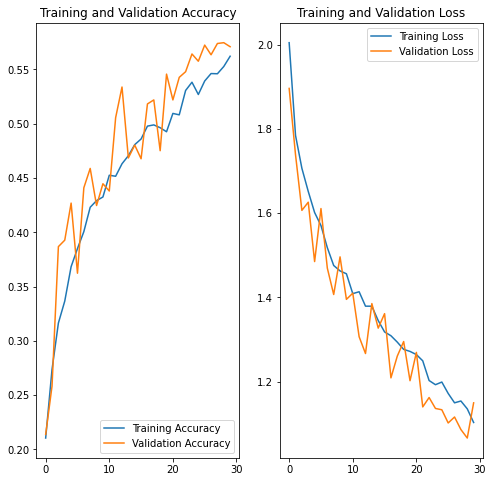

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This shows that surely <b>removing dropout has helped increase the accuracy still keeping overfitting in check.</b><br><br><font color =blue><u>To further improve from here we can increase the number of layers of Convolution and Pooling, add adding more images and increase epochs with early stopping as precaution.</u> However in terms of modelling this architecture seems like the best one to go forward with.<br><br><b>We will stop here for now as the model is finalised.</b></font>